<a id=top-page></a>
# Relating the cost function and nonlinear regression predictions

In this notebook, we explore nonlinear regression performance on 2D and 3D projections of the atmospheric physics dataset using two reduction techniques: **PCA** and **t-SNE**. 

We use the atmospheric dispersion dataset. The original dataset has `18540` observations and 16 variables. The target variable of interest is the turbulent Schmidt number, $\phi = Sc_t$. The dataset used here comes from a delayed-detached eddy simulation of an atmospheric dispersion of a pollutant in the viscinity of a rectangular building. We use a single spatial snapshot from the dataset. More information can be found in:

> [Longo et al., *A multi-fidelity framework for the estimation of the turbulent Schmidt number in the simulation of atmospheric dispersion*](https://www.sciencedirect.com/science/article/abs/pii/S0360132320304467?via%3Dihub).

The analysis in this notebook is performed in the following steps:

- [Load the atmospheric physics data](#load-data)
- [Load $\mathcal{L}$ versus regression performance results for varying manifold topologies](#load-results)
- [Measure Spearman correlation between $\mathcal{L}$ and MAE](#spearman-correlation)
- [Visualize scatter plots of $\mathcal{L}$ versus MAE](#scatter-plots)
- [Nonlinear regression of the turbulent Schmidt number, $Sc_t$, using kernel regression](#kernel-regression)
- [Nonlinear regression of the turbulent Schmidt number, $Sc_t$, using artificial neural networks (ANNs)](#ANN-regression)

***

In [1]:
%run -i imports.py
%matplotlib inline

In [2]:
bandwidth_values = np.logspace(-7, 3, 200)
penalty = 'log-sigma-over-peak'
norm = 'max'
power = 1
vertical_shift = 1
n_components = 2
data_tag = 'atmospheric-dispersion'

<a id=load-data></a>
***

## Load the atmospheric physics data

[Go to the top](#top-page)

In [3]:
X = pd.read_csv('../data/atmospheric-physics-state-space.csv', header=None).to_numpy()
X_names = pd.read_csv('../data/atmospheric-physics-state-space-names.csv', header=None).to_numpy().ravel()
X_Sct = pd.read_csv('../data/atmospheric-physics-turbulent-Schmidt-number.csv', header=None).to_numpy()
(n_observations, n_variables) = X.shape

Remove multivariate outliers from the dataset:

In [4]:
(idx_outliers_removed, idx_outliers) = preprocess.outlier_detection(X, 
                                                                    'auto', 
                                                                    method='PC CLASSIFIER', 
                                                                    quantile_threshold=0.98,
                                                                    verbose=True)

Major components that will be selected are: 1, 2
Minor components that will be selected are: 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16
Number of observations classified as outliers: 509


In [5]:
X = X[idx_outliers_removed,:]
X_Sct = X_Sct[idx_outliers_removed]

In [6]:
(n_observations, n_variables) = np.shape(X)

<a id=load-results></a>
***

## Load $\mathcal{L}$ versus regression performance results for varying manifold topologies

[Go to the top](#top-page)

In [7]:
PCA_level_costs = pd.read_csv('../results/PCA-random-subsets-level-scaling-' + str(n_components) + 'D-LDM-optimizing-on-Sct-costs.csv', header=None).to_numpy().ravel()
PCA_auto_costs = pd.read_csv('../results/PCA-random-subsets-auto-scaling-' + str(n_components) + 'D-LDM-optimizing-on-Sct-costs.csv', header=None).to_numpy().ravel()
PCA_S1_costs = pd.read_csv('../results/PCA-random-subsets-vast_2-scaling-' + str(n_components) + 'D-LDM-optimizing-on-Sct-costs.csv', header=None).to_numpy().ravel()
PCA_pareto_costs = pd.read_csv('../results/PCA-random-subsets-pareto-scaling-' + str(n_components) + 'D-LDM-optimizing-on-Sct-costs.csv', header=None).to_numpy().ravel()
PCA_vast_costs = pd.read_csv('../results/PCA-random-subsets-vast-scaling-' + str(n_components) + 'D-LDM-optimizing-on-Sct-costs.csv', header=None).to_numpy().ravel()
PCA_0to1_costs = pd.read_csv('../results/PCA-random-subsets-0to1-scaling-' + str(n_components) + 'D-LDM-optimizing-on-Sct-costs.csv', header=None).to_numpy().ravel()

In [8]:
PCA_costs = np.vstack((PCA_auto_costs[:,None], PCA_pareto_costs[:,None], PCA_vast_costs[:,None], PCA_0to1_costs[:,None], PCA_level_costs[:,None], PCA_S1_costs[:,None]))

In [9]:
tSNE_level_costs = pd.read_csv('../results/t-SNE-random-subsets-level-scaling-' + str(n_components) + 'D-LDM-optimizing-on-Sct-costs.csv', header=None).to_numpy().ravel()
tSNE_auto_costs = pd.read_csv('../results/t-SNE-random-subsets-auto-scaling-' + str(n_components) + 'D-LDM-optimizing-on-Sct-costs.csv', header=None).to_numpy().ravel()
tSNE_S1_costs = pd.read_csv('../results/t-SNE-random-subsets-vast_2-scaling-' + str(n_components) + 'D-LDM-optimizing-on-Sct-costs.csv', header=None).to_numpy().ravel()
tSNE_pareto_costs = pd.read_csv('../results/t-SNE-random-subsets-pareto-scaling-' + str(n_components) + 'D-LDM-optimizing-on-Sct-costs.csv', header=None).to_numpy().ravel()
tSNE_vast_costs = pd.read_csv('../results/t-SNE-random-subsets-vast-scaling-' + str(n_components) + 'D-LDM-optimizing-on-Sct-costs.csv', header=None).to_numpy().ravel()
tSNE_0to1_costs = pd.read_csv('../results/t-SNE-random-subsets-0to1-scaling-' + str(n_components) + 'D-LDM-optimizing-on-Sct-costs.csv', header=None).to_numpy().ravel()

In [10]:
tSNE_costs = np.vstack((tSNE_auto_costs[:,None], tSNE_pareto_costs[:,None], tSNE_vast_costs[:,None], tSNE_0to1_costs[:,None], tSNE_level_costs[:,None], tSNE_S1_costs[:,None]))

In [11]:
KReg_PCA_level_MAE = pd.read_csv('../results/kernel-regression-PCA-random-subsets-level-scaling-' + str(n_components) + 'D-LDM-optimizing-on-Sct-MAE.csv', header=None).to_numpy().ravel()
KReg_PCA_auto_MAE = pd.read_csv('../results/kernel-regression-PCA-random-subsets-auto-scaling-' + str(n_components) + 'D-LDM-optimizing-on-Sct-MAE.csv', header=None).to_numpy().ravel()
KReg_PCA_S1_MAE = pd.read_csv('../results/kernel-regression-PCA-random-subsets-vast_2-scaling-' + str(n_components) + 'D-LDM-optimizing-on-Sct-MAE.csv', header=None).to_numpy().ravel()
KReg_PCA_pareto_MAE = pd.read_csv('../results/kernel-regression-PCA-random-subsets-pareto-scaling-' + str(n_components) + 'D-LDM-optimizing-on-Sct-MAE.csv', header=None).to_numpy().ravel()
KReg_PCA_vast_MAE = pd.read_csv('../results/kernel-regression-PCA-random-subsets-vast-scaling-' + str(n_components) + 'D-LDM-optimizing-on-Sct-MAE.csv', header=None).to_numpy().ravel()
KReg_PCA_0to1_MAE = pd.read_csv('../results/kernel-regression-PCA-random-subsets-0to1-scaling-' + str(n_components) + 'D-LDM-optimizing-on-Sct-MAE.csv', header=None).to_numpy().ravel()

In [12]:
KReg_tSNE_level_MAE = pd.read_csv('../results/kernel-regression-t-SNE-random-subsets-level-scaling-' + str(n_components) + 'D-LDM-optimizing-on-Sct-MAE.csv', header=None).to_numpy().ravel()
KReg_tSNE_auto_MAE = pd.read_csv('../results/kernel-regression-t-SNE-random-subsets-auto-scaling-' + str(n_components) + 'D-LDM-optimizing-on-Sct-MAE.csv', header=None).to_numpy().ravel()
KReg_tSNE_S1_MAE = pd.read_csv('../results/kernel-regression-t-SNE-random-subsets-vast_2-scaling-' + str(n_components) + 'D-LDM-optimizing-on-Sct-MAE.csv', header=None).to_numpy().ravel()
KReg_tSNE_pareto_MAE = pd.read_csv('../results/kernel-regression-t-SNE-random-subsets-pareto-scaling-' + str(n_components) + 'D-LDM-optimizing-on-Sct-MAE.csv', header=None).to_numpy().ravel()
KReg_tSNE_vast_MAE = pd.read_csv('../results/kernel-regression-t-SNE-random-subsets-vast-scaling-' + str(n_components) + 'D-LDM-optimizing-on-Sct-MAE.csv', header=None).to_numpy().ravel()
KReg_tSNE_0to1_MAE = pd.read_csv('../results/kernel-regression-t-SNE-random-subsets-0to1-scaling-' + str(n_components) + 'D-LDM-optimizing-on-Sct-MAE.csv', header=None).to_numpy().ravel()

In [13]:
ANN_PCA_level_MAE = pd.read_csv('../results/ANN-regression-PCA-random-subsets-level-scaling-' + str(n_components) + 'D-LDM-optimizing-on-Sct-MAE.csv', header=None).to_numpy().ravel()
ANN_PCA_auto_MAE = pd.read_csv('../results/ANN-regression-PCA-random-subsets-auto-scaling-' + str(n_components) + 'D-LDM-optimizing-on-Sct-MAE.csv', header=None).to_numpy().ravel()
ANN_PCA_S1_MAE = pd.read_csv('../results/ANN-regression-PCA-random-subsets-vast_2-scaling-' + str(n_components) + 'D-LDM-optimizing-on-Sct-MAE.csv', header=None).to_numpy().ravel()
ANN_PCA_pareto_MAE = pd.read_csv('../results/ANN-regression-PCA-random-subsets-pareto-scaling-' + str(n_components) + 'D-LDM-optimizing-on-Sct-MAE.csv', header=None).to_numpy().ravel()
ANN_PCA_vast_MAE = pd.read_csv('../results/ANN-regression-PCA-random-subsets-vast-scaling-' + str(n_components) + 'D-LDM-optimizing-on-Sct-MAE.csv', header=None).to_numpy().ravel()
ANN_PCA_0to1_MAE = pd.read_csv('../results/ANN-regression-PCA-random-subsets-0to1-scaling-' + str(n_components) + 'D-LDM-optimizing-on-Sct-MAE.csv', header=None).to_numpy().ravel()

In [14]:
ANN_tSNE_level_MAE = pd.read_csv('../results/ANN-regression-t-SNE-random-subsets-level-scaling-' + str(n_components) + 'D-LDM-optimizing-on-Sct-MAE.csv', header=None).to_numpy().ravel()
ANN_tSNE_auto_MAE = pd.read_csv('../results/ANN-regression-t-SNE-random-subsets-auto-scaling-' + str(n_components) + 'D-LDM-optimizing-on-Sct-MAE.csv', header=None).to_numpy().ravel()
ANN_tSNE_S1_MAE = pd.read_csv('../results/ANN-regression-t-SNE-random-subsets-vast_2-scaling-' + str(n_components) + 'D-LDM-optimizing-on-Sct-MAE.csv', header=None).to_numpy().ravel()
ANN_tSNE_pareto_MAE = pd.read_csv('../results/ANN-regression-t-SNE-random-subsets-pareto-scaling-' + str(n_components) + 'D-LDM-optimizing-on-Sct-MAE.csv', header=None).to_numpy().ravel()
ANN_tSNE_vast_MAE = pd.read_csv('../results/ANN-regression-t-SNE-random-subsets-vast-scaling-' + str(n_components) + 'D-LDM-optimizing-on-Sct-MAE.csv', header=None).to_numpy().ravel()
ANN_tSNE_0to1_MAE = pd.read_csv('../results/ANN-regression-t-SNE-random-subsets-0to1-scaling-' + str(n_components) + 'D-LDM-optimizing-on-Sct-MAE.csv', header=None).to_numpy().ravel()

<a id=spearman-correlation></a>
***

## Measure Spearman correlation between $\mathcal{L}$ and MAE

[Go to the top](#top-page)

#### PCA projections, ANN regression

In [15]:
errors = np.vstack((ANN_PCA_auto_MAE[:,None], ANN_PCA_pareto_MAE[:,None], ANN_PCA_vast_MAE[:,None], ANN_PCA_0to1_MAE[:,None], ANN_PCA_level_MAE[:,None], ANN_PCA_S1_MAE[:,None]))
(PCA_ANN_corr, _) = spearmanr(PCA_costs, errors)
round(PCA_ANN_corr*100,1)

96.0

#### PCA projections, kernel regression

In [16]:
errors = np.vstack((KReg_PCA_auto_MAE[:,None], KReg_PCA_pareto_MAE[:,None], KReg_PCA_vast_MAE[:,None], KReg_PCA_0to1_MAE[:,None], KReg_PCA_level_MAE[:,None], KReg_PCA_S1_MAE[:,None]))
(PCA_KReg_corr, _) = spearmanr(PCA_costs, errors)
round(PCA_KReg_corr*100,1)

89.9

#### t-SNE projections, ANN regression

In [17]:
errors = np.vstack((ANN_tSNE_auto_MAE[:,None], ANN_tSNE_pareto_MAE[:,None], ANN_tSNE_vast_MAE[:,None], ANN_tSNE_0to1_MAE[:,None], ANN_tSNE_level_MAE[:,None], ANN_tSNE_S1_MAE[:,None]))
(tSNE_ANN_corr, _) = spearmanr(tSNE_costs, errors)
round(tSNE_ANN_corr*100,1)

96.1

#### t-SNE projections, kernel regression

In [18]:
errors = np.vstack((KReg_tSNE_auto_MAE[:,None], KReg_tSNE_pareto_MAE[:,None], KReg_tSNE_vast_MAE[:,None], KReg_tSNE_0to1_MAE[:,None], KReg_tSNE_level_MAE[:,None], KReg_tSNE_S1_MAE[:,None]))
(tSNE_KReg_corr, _) = spearmanr(tSNE_costs, errors)
round(tSNE_KReg_corr*100,1)

93.3

<a id=scatter-plots></a>
***

## Visualize scatter plots of $\mathcal{L}$ versus MAE

[Go to the top](#top-page)

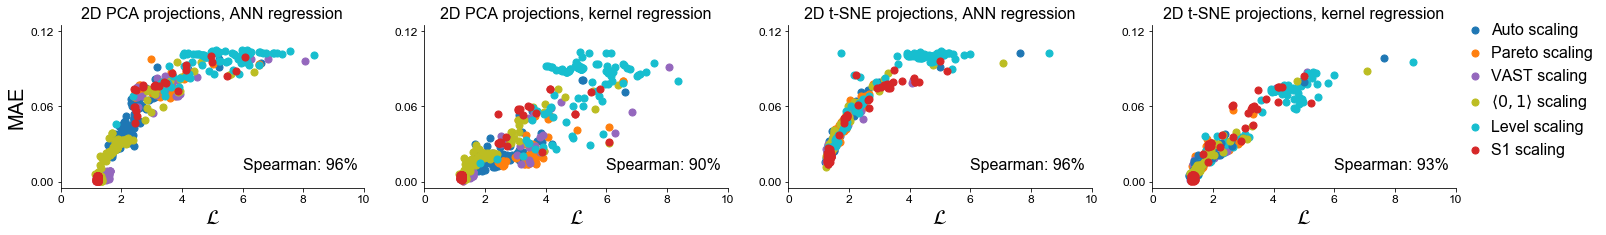

In [19]:
color_map_colors = cm.get_cmap('tab10', 10)
colors = color_map_colors(np.linspace(0, 1, 10))
color_auto = colors[0:1,:]
color_pareto = colors[1:2,:]
color_vast = colors[4:5,:]
color_0to1 = colors[8:9,:]
color_level = colors[9:10,:]
color_s1 = colors[3:4,:]

fig = plt.figure(figsize=(25, 3))
spec = fig.add_gridspec(ncols=4, nrows=1, width_ratios=[1,1,1,1], height_ratios=[1])

point_size = 50

ax1 = fig.add_subplot(spec[0,0])
plt.scatter(PCA_auto_costs, ANN_PCA_auto_MAE, c=color_auto, s=point_size, label='Auto scaling')
plt.scatter(PCA_pareto_costs, ANN_PCA_pareto_MAE, c=color_pareto, s=point_size, label='Pareto scaling')
plt.scatter(PCA_vast_costs, ANN_PCA_vast_MAE, c=color_vast, s=point_size, label='VAST scaling')
plt.scatter(PCA_0to1_costs, ANN_PCA_0to1_MAE, c=color_0to1, s=point_size, label='$\\langle 0, 1 \\rangle$ scaling')
plt.scatter(PCA_level_costs, ANN_PCA_level_MAE, c=color_level, s=point_size, label='Level scaling')
plt.scatter(PCA_S1_costs, ANN_PCA_S1_MAE, c=color_s1, s=point_size, label='S1 scaling', zorder=200)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
plt.ylim([-0.005,0.125])
plt.xlim([0,10])
plt.xticks([0,2,4,6,8,10], fontsize=12)
plt.yticks([0,0.06,0.12], fontsize=12)
plt.xlabel('$\mathcal{L}$', fontsize=20)
ax1.set_ylabel('MAE', fontsize=20, rotation=90)
plt.title(str(n_components) + 'D PCA projections, ANN regression', fontsize=16)
plt.text(6, 0.01, 'Spearman: %.0f' % (PCA_ANN_corr*100) + '%', fontsize=16)

ax2 = fig.add_subplot(spec[0,1])
plt.scatter(PCA_auto_costs, KReg_PCA_auto_MAE, c=color_auto, s=point_size, label='Auto scaling')
plt.scatter(PCA_pareto_costs, KReg_PCA_pareto_MAE, c=color_pareto, s=point_size, label='Pareto scaling')
plt.scatter(PCA_vast_costs, KReg_PCA_vast_MAE, c=color_vast, s=point_size, label='VAST scaling')
plt.scatter(PCA_0to1_costs, KReg_PCA_0to1_MAE, c=color_0to1, s=point_size, label='$\\langle 0, 1 \\rangle$ scaling')
plt.scatter(PCA_level_costs, KReg_PCA_level_MAE, c=color_level, s=point_size, label='Level scaling')
plt.scatter(PCA_S1_costs, KReg_PCA_S1_MAE, c=color_s1, s=point_size, label='S1 scaling', zorder=200)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
plt.ylim([-0.005,0.125])
plt.xlim([0,10])
plt.xticks([0,2,4,6,8,10], fontsize=12)
plt.yticks([0,0.06,0.12], fontsize=12)
plt.xlabel('$\mathcal{L}$', fontsize=20)
plt.title(str(n_components) + 'D PCA projections, kernel regression', fontsize=16)
plt.text(6, 0.01, 'Spearman: %.0f' % (PCA_KReg_corr*100) + '%', fontsize=16)

ax3 = fig.add_subplot(spec[0,2])
plt.scatter(tSNE_auto_costs, ANN_tSNE_auto_MAE, c=color_auto, s=point_size, label='Auto scaling')
plt.scatter(tSNE_pareto_costs, ANN_tSNE_pareto_MAE, c=color_pareto, s=point_size, label='Pareto scaling')
plt.scatter(tSNE_vast_costs, ANN_tSNE_vast_MAE, c=color_vast, s=point_size, label='VAST scaling')
plt.scatter(tSNE_0to1_costs, ANN_tSNE_0to1_MAE, c=color_0to1, s=point_size, label='$\\langle 0, 1 \\rangle$ scaling')
plt.scatter(tSNE_level_costs, ANN_tSNE_level_MAE, c=color_level, s=point_size, label='Level scaling')
plt.scatter(tSNE_S1_costs, ANN_tSNE_S1_MAE, c=color_s1, s=point_size, label='S1 scaling', zorder=200)
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
plt.ylim([-0.005,0.125])
plt.xlim([0,10])
plt.xticks([0,2,4,6,8,10], fontsize=12)
plt.yticks([0,0.06,0.12], fontsize=12)
plt.xlabel('$\mathcal{L}$', fontsize=20)
plt.title(str(n_components) + 'D t-SNE projections, ANN regression', fontsize=16)
plt.text(6, 0.01, 'Spearman: %.0f' % (tSNE_ANN_corr*100) + '%', fontsize=16)

ax4 = fig.add_subplot(spec[0,3])
plt.scatter(tSNE_auto_costs, KReg_tSNE_auto_MAE, c=color_auto, s=point_size, label='Auto scaling', zorder=100)
plt.scatter(tSNE_pareto_costs, KReg_tSNE_pareto_MAE, c=color_pareto, s=point_size, label='Pareto scaling')
plt.scatter(tSNE_vast_costs, KReg_tSNE_vast_MAE, c=color_vast, s=point_size, label='VAST scaling')
plt.scatter(tSNE_0to1_costs, KReg_tSNE_0to1_MAE, c=color_0to1, s=point_size, label='$\\langle 0, 1 \\rangle$ scaling', zorder=100)
plt.scatter(tSNE_level_costs, KReg_tSNE_level_MAE, c=color_level, s=point_size, label='Level scaling')
plt.scatter(tSNE_S1_costs, KReg_tSNE_S1_MAE, c=color_s1, s=point_size, label='S1 scaling', zorder=200)
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)
plt.ylim([-0.005,0.125])
plt.xlim([0,10])
plt.xticks([0,2,4,6,8,10], fontsize=12)
plt.yticks([0,0.06,0.12], fontsize=12)
plt.xlabel('$\mathcal{L}$', fontsize=20)
plt.title(str(n_components) + 'D t-SNE projections, kernel regression', fontsize=16)
plt.text(6, 0.01, 'Spearman: %.0f' % (tSNE_KReg_corr*100) + '%', fontsize=16)
plt.legend(ncol=1, frameon=False, loc='lower right', handletextpad=0, fontsize=16, columnspacing=0, bbox_to_anchor=(1.5,0.1))

plt.savefig('../figures/paper-Figure-7-' + str(n_components) + 'D-LDM.png', dpi=400, bbox_inches='tight')

### Visualize one scaling at a time

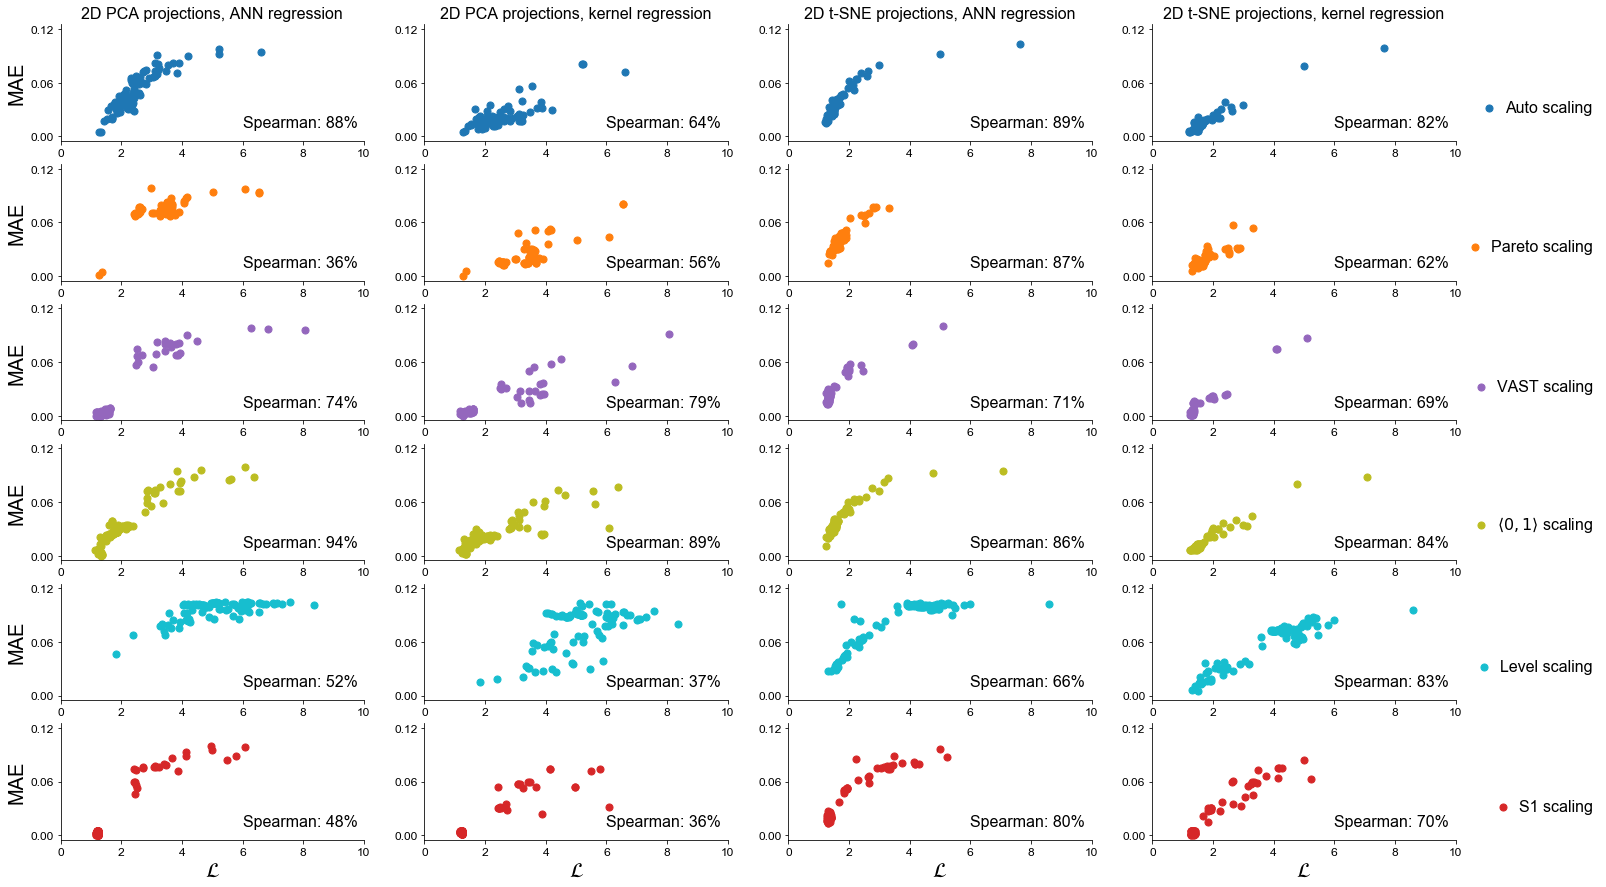

In [20]:
color_map_colors = cm.get_cmap('tab10', 10)
colors = color_map_colors(np.linspace(0, 1, 10))
color_auto = colors[0:1,:]
color_pareto = colors[1:2,:]
color_vast = colors[4:5,:]
color_0to1 = colors[8:9,:]
color_level = colors[9:10,:]
color_s1 = colors[3:4,:]

fig = plt.figure(figsize=(25, 15))
spec = fig.add_gridspec(ncols=4, nrows=6, width_ratios=[1,1,1,1], height_ratios=[1,1,1,1,1,1])

point_size = 50

ax1 = fig.add_subplot(spec[0,0])
plt.scatter(PCA_auto_costs, ANN_PCA_auto_MAE, c=color_auto, s=point_size, label='Auto scaling')
(current_corr, _) = spearmanr(PCA_auto_costs, ANN_PCA_auto_MAE)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
plt.ylim([-0.005,0.125])
plt.xlim([0,10])
plt.xticks([0,2,4,6,8,10], fontsize=12)
plt.yticks([0,0.06,0.12], fontsize=12)
plt.xlabel('$\mathcal{L}$', fontsize=20)
ax1.set_ylabel('MAE', fontsize=20, rotation=90)
plt.title(str(n_components) + 'D PCA projections, ANN regression', fontsize=16)
plt.text(6, 0.01, 'Spearman: %.0f' % (current_corr*100) + '%', fontsize=16)

ax1 = fig.add_subplot(spec[1,0])
plt.scatter(PCA_pareto_costs, ANN_PCA_pareto_MAE, c=color_pareto, s=point_size, label='Pareto scaling')
(current_corr, _) = spearmanr(PCA_pareto_costs, ANN_PCA_pareto_MAE)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
plt.ylim([-0.005,0.125])
plt.xlim([0,10])
plt.xticks([0,2,4,6,8,10], fontsize=12)
plt.yticks([0,0.06,0.12], fontsize=12)
ax1.set_ylabel('MAE', fontsize=20, rotation=90)
plt.text(6, 0.01, 'Spearman: %.0f' % (current_corr*100) + '%', fontsize=16)

ax1 = fig.add_subplot(spec[2,0])
plt.scatter(PCA_vast_costs, ANN_PCA_vast_MAE, c=color_vast, s=point_size, label='VAST scaling')
(current_corr, _) = spearmanr(PCA_vast_costs, ANN_PCA_vast_MAE)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
plt.ylim([-0.005,0.125])
plt.xlim([0,10])
plt.xticks([0,2,4,6,8,10], fontsize=12)
plt.yticks([0,0.06,0.12], fontsize=12)
ax1.set_ylabel('MAE', fontsize=20, rotation=90)
plt.text(6, 0.01, 'Spearman: %.0f' % (current_corr*100) + '%', fontsize=16)

ax1 = fig.add_subplot(spec[3,0])
plt.scatter(PCA_0to1_costs, ANN_PCA_0to1_MAE, c=color_0to1, s=point_size, label='$\\langle 0, 1 \\rangle$ scaling')
(current_corr, _) = spearmanr(PCA_0to1_costs, ANN_PCA_0to1_MAE)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
plt.ylim([-0.005,0.125])
plt.xlim([0,10])
plt.xticks([0,2,4,6,8,10], fontsize=12)
plt.yticks([0,0.06,0.12], fontsize=12)
ax1.set_ylabel('MAE', fontsize=20, rotation=90)
plt.text(6, 0.01, 'Spearman: %.0f' % (current_corr*100) + '%', fontsize=16)

ax1 = fig.add_subplot(spec[4,0])
plt.scatter(PCA_level_costs, ANN_PCA_level_MAE, c=color_level, s=point_size, label='Level scaling')
(current_corr, _) = spearmanr(PCA_level_costs, ANN_PCA_level_MAE)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
plt.ylim([-0.005,0.125])
plt.xlim([0,10])
plt.xticks([0,2,4,6,8,10], fontsize=12)
plt.yticks([0,0.06,0.12], fontsize=12)
ax1.set_ylabel('MAE', fontsize=20, rotation=90)
plt.text(6, 0.01, 'Spearman: %.0f' % (current_corr*100) + '%', fontsize=16)

ax1 = fig.add_subplot(spec[5,0])
plt.scatter(PCA_S1_costs, ANN_PCA_S1_MAE, c=color_s1, s=point_size, label='S1 scaling', zorder=200)
(current_corr, _) = spearmanr(PCA_S1_costs, ANN_PCA_S1_MAE)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
plt.ylim([-0.005,0.125])
plt.xlim([0,10])
plt.xticks([0,2,4,6,8,10], fontsize=12)
plt.yticks([0,0.06,0.12], fontsize=12)
plt.xlabel('$\mathcal{L}$', fontsize=20)
ax1.set_ylabel('MAE', fontsize=20, rotation=90)
plt.text(6, 0.01, 'Spearman: %.0f' % (current_corr*100) + '%', fontsize=16)

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

ax2 = fig.add_subplot(spec[0,1])
plt.scatter(PCA_auto_costs, KReg_PCA_auto_MAE, c=color_auto, s=point_size, label='Auto scaling')
(current_corr, _) = spearmanr(PCA_auto_costs, KReg_PCA_auto_MAE)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
plt.ylim([-0.005,0.125])
plt.xlim([0,10])
plt.xticks([0,2,4,6,8,10], fontsize=12)
plt.yticks([0,0.06,0.12], fontsize=12)
plt.title(str(n_components) + 'D PCA projections, kernel regression', fontsize=16)
plt.text(6, 0.01, 'Spearman: %.0f' % (current_corr*100) + '%', fontsize=16)

ax2 = fig.add_subplot(spec[1,1])
plt.scatter(PCA_pareto_costs, KReg_PCA_pareto_MAE, c=color_pareto, s=point_size, label='Pareto scaling')
(current_corr, _) = spearmanr(PCA_pareto_costs, KReg_PCA_pareto_MAE)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
plt.ylim([-0.005,0.125])
plt.xlim([0,10])
plt.xticks([0,2,4,6,8,10], fontsize=12)
plt.yticks([0,0.06,0.12], fontsize=12)
plt.text(6, 0.01, 'Spearman: %.0f' % (current_corr*100) + '%', fontsize=16)

ax2 = fig.add_subplot(spec[2,1])
plt.scatter(PCA_vast_costs, KReg_PCA_vast_MAE, c=color_vast, s=point_size, label='VAST scaling')
(current_corr, _) = spearmanr(PCA_vast_costs, KReg_PCA_vast_MAE)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
plt.ylim([-0.005,0.125])
plt.xlim([0,10])
plt.xticks([0,2,4,6,8,10], fontsize=12)
plt.yticks([0,0.06,0.12], fontsize=12)
plt.text(6, 0.01, 'Spearman: %.0f' % (current_corr*100) + '%', fontsize=16)

ax2 = fig.add_subplot(spec[3,1])
plt.scatter(PCA_0to1_costs, KReg_PCA_0to1_MAE, c=color_0to1, s=point_size, label='$\\langle 0, 1 \\rangle$ scaling')
(current_corr, _) = spearmanr(PCA_0to1_costs, KReg_PCA_0to1_MAE)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
plt.ylim([-0.005,0.125])
plt.xlim([0,10])
plt.xticks([0,2,4,6,8,10], fontsize=12)
plt.yticks([0,0.06,0.12], fontsize=12)
plt.text(6, 0.01, 'Spearman: %.0f' % (current_corr*100) + '%', fontsize=16)

ax2 = fig.add_subplot(spec[4,1])
plt.scatter(PCA_level_costs, KReg_PCA_level_MAE, c=color_level, s=point_size, label='Level scaling')
(current_corr, _) = spearmanr(PCA_level_costs, KReg_PCA_level_MAE)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
plt.ylim([-0.005,0.125])
plt.xlim([0,10])
plt.xticks([0,2,4,6,8,10], fontsize=12)
plt.yticks([0,0.06,0.12], fontsize=12)
plt.text(6, 0.01, 'Spearman: %.0f' % (current_corr*100) + '%', fontsize=16)

ax2 = fig.add_subplot(spec[5,1])
plt.scatter(PCA_S1_costs, KReg_PCA_S1_MAE, c=color_s1, s=point_size, label='S1 scaling', zorder=200)
(current_corr, _) = spearmanr(PCA_S1_costs, KReg_PCA_S1_MAE)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
plt.ylim([-0.005,0.125])
plt.xlim([0,10])
plt.xticks([0,2,4,6,8,10], fontsize=12)
plt.yticks([0,0.06,0.12], fontsize=12)
plt.xlabel('$\mathcal{L}$', fontsize=20)
plt.text(6, 0.01, 'Spearman: %.0f' % (current_corr*100) + '%', fontsize=16)

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

ax3 = fig.add_subplot(spec[0,2])
plt.scatter(tSNE_auto_costs, ANN_tSNE_auto_MAE, c=color_auto, s=point_size, label='Auto scaling')
(current_corr, _) = spearmanr(tSNE_auto_costs, ANN_tSNE_auto_MAE)
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
plt.ylim([-0.005,0.125])
plt.xlim([0,10])
plt.xticks([0,2,4,6,8,10], fontsize=12)
plt.yticks([0,0.06,0.12], fontsize=12)
plt.title(str(n_components) + 'D t-SNE projections, ANN regression', fontsize=16)
plt.text(6, 0.01, 'Spearman: %.0f' % (current_corr*100) + '%', fontsize=16)

ax3 = fig.add_subplot(spec[1,2])
plt.scatter(tSNE_pareto_costs, ANN_tSNE_pareto_MAE, c=color_pareto, s=point_size, label='Pareto scaling')
(current_corr, _) = spearmanr(tSNE_pareto_costs, ANN_tSNE_pareto_MAE)
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
plt.ylim([-0.005,0.125])
plt.xlim([0,10])
plt.xticks([0,2,4,6,8,10], fontsize=12)
plt.yticks([0,0.06,0.12], fontsize=12)
plt.text(6, 0.01, 'Spearman: %.0f' % (current_corr*100) + '%', fontsize=16)

ax3 = fig.add_subplot(spec[2,2])
plt.scatter(tSNE_vast_costs, ANN_tSNE_vast_MAE, c=color_vast, s=point_size, label='VAST scaling')
(current_corr, _) = spearmanr(tSNE_vast_costs, ANN_tSNE_vast_MAE)
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
plt.ylim([-0.005,0.125])
plt.xlim([0,10])
plt.xticks([0,2,4,6,8,10], fontsize=12)
plt.yticks([0,0.06,0.12], fontsize=12)
plt.text(6, 0.01, 'Spearman: %.0f' % (current_corr*100) + '%', fontsize=16)

ax3 = fig.add_subplot(spec[3,2])
plt.scatter(tSNE_0to1_costs, ANN_tSNE_0to1_MAE, c=color_0to1, s=point_size, label='$\\langle 0, 1 \\rangle$ scaling')
(current_corr, _) = spearmanr(tSNE_0to1_costs, ANN_tSNE_0to1_MAE)
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
plt.ylim([-0.005,0.125])
plt.xlim([0,10])
plt.xticks([0,2,4,6,8,10], fontsize=12)
plt.yticks([0,0.06,0.12], fontsize=12)
plt.text(6, 0.01, 'Spearman: %.0f' % (current_corr*100) + '%', fontsize=16)

ax3 = fig.add_subplot(spec[4,2])
plt.scatter(tSNE_level_costs, ANN_tSNE_level_MAE, c=color_level, s=point_size, label='Level scaling')
(current_corr, _) = spearmanr(tSNE_level_costs, ANN_tSNE_level_MAE)
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
plt.ylim([-0.005,0.125])
plt.xlim([0,10])
plt.xticks([0,2,4,6,8,10], fontsize=12)
plt.yticks([0,0.06,0.12], fontsize=12)
plt.text(6, 0.01, 'Spearman: %.0f' % (current_corr*100) + '%', fontsize=16)

ax3 = fig.add_subplot(spec[5,2])
plt.scatter(tSNE_S1_costs, ANN_tSNE_S1_MAE, c=color_s1, s=point_size, label='S1 scaling', zorder=200)
(current_corr, _) = spearmanr(tSNE_S1_costs, ANN_tSNE_S1_MAE)
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
plt.ylim([-0.005,0.125])
plt.xlim([0,10])
plt.xticks([0,2,4,6,8,10], fontsize=12)
plt.yticks([0,0.06,0.12], fontsize=12)
plt.xlabel('$\mathcal{L}$', fontsize=20)
plt.text(6, 0.01, 'Spearman: %.0f' % (current_corr*100) + '%', fontsize=16)

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

ax4 = fig.add_subplot(spec[0,3])
plt.scatter(tSNE_auto_costs, KReg_tSNE_auto_MAE, c=color_auto, s=point_size, label='Auto scaling', zorder=100)
(current_corr, _) = spearmanr(tSNE_auto_costs, KReg_tSNE_auto_MAE)
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)
plt.ylim([-0.005,0.125])
plt.xlim([0,10])
plt.xticks([0,2,4,6,8,10], fontsize=12)
plt.yticks([0,0.06,0.12], fontsize=12)
plt.title(str(n_components) + 'D t-SNE projections, kernel regression', fontsize=16)
plt.text(6, 0.01, 'Spearman: %.0f' % (current_corr*100) + '%', fontsize=16)
plt.legend(ncol=1, frameon=False, loc='lower right', handletextpad=0, fontsize=16, columnspacing=0, bbox_to_anchor=(1.5,0.1))

ax4 = fig.add_subplot(spec[1,3])
plt.scatter(tSNE_pareto_costs, KReg_tSNE_pareto_MAE, c=color_pareto, s=point_size, label='Pareto scaling')
(current_corr, _) = spearmanr(tSNE_pareto_costs, KReg_tSNE_pareto_MAE)
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)
plt.ylim([-0.005,0.125])
plt.xlim([0,10])
plt.xticks([0,2,4,6,8,10], fontsize=12)
plt.yticks([0,0.06,0.12], fontsize=12)
plt.text(6, 0.01, 'Spearman: %.0f' % (current_corr*100) + '%', fontsize=16)
plt.legend(ncol=1, frameon=False, loc='lower right', handletextpad=0, fontsize=16, columnspacing=0, bbox_to_anchor=(1.5,0.1))

ax4 = fig.add_subplot(spec[2,3])
plt.scatter(tSNE_vast_costs, KReg_tSNE_vast_MAE, c=color_vast, s=point_size, label='VAST scaling')
(current_corr, _) = spearmanr(tSNE_vast_costs, KReg_tSNE_vast_MAE)
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)
plt.ylim([-0.005,0.125])
plt.xlim([0,10])
plt.xticks([0,2,4,6,8,10], fontsize=12)
plt.yticks([0,0.06,0.12], fontsize=12)
plt.text(6, 0.01, 'Spearman: %.0f' % (current_corr*100) + '%', fontsize=16)
plt.legend(ncol=1, frameon=False, loc='lower right', handletextpad=0, fontsize=16, columnspacing=0, bbox_to_anchor=(1.5,0.1))

ax4 = fig.add_subplot(spec[3,3])
plt.scatter(tSNE_0to1_costs, KReg_tSNE_0to1_MAE, c=color_0to1, s=point_size, label='$\\langle 0, 1 \\rangle$ scaling', zorder=100)
(current_corr, _) = spearmanr(tSNE_0to1_costs, KReg_tSNE_0to1_MAE)
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)
plt.ylim([-0.005,0.125])
plt.xlim([0,10])
plt.xticks([0,2,4,6,8,10], fontsize=12)
plt.yticks([0,0.06,0.12], fontsize=12)
plt.text(6, 0.01, 'Spearman: %.0f' % (current_corr*100) + '%', fontsize=16)
plt.legend(ncol=1, frameon=False, loc='lower right', handletextpad=0, fontsize=16, columnspacing=0, bbox_to_anchor=(1.5,0.1))

ax4 = fig.add_subplot(spec[4,3])
plt.scatter(tSNE_level_costs, KReg_tSNE_level_MAE, c=color_level, s=point_size, label='Level scaling')
(current_corr, _) = spearmanr(tSNE_level_costs, KReg_tSNE_level_MAE)
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)
plt.ylim([-0.005,0.125])
plt.xlim([0,10])
plt.xticks([0,2,4,6,8,10], fontsize=12)
plt.yticks([0,0.06,0.12], fontsize=12)
plt.text(6, 0.01, 'Spearman: %.0f' % (current_corr*100) + '%', fontsize=16)
plt.legend(ncol=1, frameon=False, loc='lower right', handletextpad=0, fontsize=16, columnspacing=0, bbox_to_anchor=(1.5,0.1))

ax4 = fig.add_subplot(spec[5,3])
plt.scatter(tSNE_S1_costs, KReg_tSNE_S1_MAE, c=color_s1, s=point_size, label='S1 scaling', zorder=200)
(current_corr, _) = spearmanr(tSNE_S1_costs, KReg_tSNE_S1_MAE)
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)
plt.ylim([-0.005,0.125])
plt.xlim([0,10])
plt.xticks([0,2,4,6,8,10], fontsize=12)
plt.yticks([0,0.06,0.12], fontsize=12)
plt.xlabel('$\mathcal{L}$', fontsize=20)
plt.text(6, 0.01, 'Spearman: %.0f' % (current_corr*100) + '%', fontsize=16)
plt.legend(ncol=1, frameon=False, loc='lower right', handletextpad=0, fontsize=16, columnspacing=0, bbox_to_anchor=(1.5,0.1))

plt.savefig('../figures/paper-Figure-7-' + str(n_components) + 'D-LDM-one-scaling-at-a-time.png', dpi=400, bbox_inches='tight')

<a id=kernel-regression></a>
***

## Nonlinear regression of the turbulent Schmidt number, $Sc_t$, using kernel regression

[Go to the top](#top-page)

<p style="color:green;">► You only need to run this once to generate the `csv` files in `../results/`:</p>

In [ ]:
train_perc = 80
n_neighbors = 50

n_cases = 100 # specifies the number of different manifold topologies that will be generated for each scaling option
scalings_list = ['auto', 'level', 'pareto', 'vast_2', 'vast', '0to1']
technique_name = 't-SNE'

In [ ]:
total_tic = time.perf_counter()

for scaling in scalings_list:

    costs_combined = []
    kernel_regression_MAE = []
    selected_variables_list = []

    for i in range(0,n_cases):

        tic = time.perf_counter()
        
        print('Case ' + str(i+1))

        # Cost function computation - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

        # Randomly select state variables:
        random.seed(a=None, version=2)
        how_many_variables = random.sample([i for i in range(n_components, len(X_names)+1)], 1)
        base_variables_list = random.sample([i for i in range(0,len(X_names))], how_many_variables[0])
        selected_variables_list.append(base_variables_list)

        if technique_name == 't-SNE':
            (X_cs, _, _) = preprocess.center_scale(X[:,base_variables_list], scaling=scaling)
            X_projected = manifold.TSNE(n_components=n_components, init="pca", random_state=random_seed).fit_transform(X_cs)
            
        elif technique_name == 'PCA':
            pca = reduction.PCA(X[:,base_variables_list], scaling=scaling, n_components=n_components)
            X_projected = pca.transform(X[:,base_variables_list])

        variance_data_base = analysis.compute_normalized_variance(X_projected, 
                                                                  X_Sct, 
                                                                  depvar_names=['Sct'],
                                                                  scale_unit_box=True,
                                                                  bandwidth_values=bandwidth_values)

        cost = analysis.cost_function_normalized_variance_derivative(variance_data_base, 
                                                                     penalty_function=penalty, 
                                                                     power=power,
                                                                     vertical_shift=vertical_shift,
                                                                     norm=norm, 
                                                                     integrate_to_peak=False)
        
        costs_combined.append(cost)
        
        # Kernel regression - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

        (X_projected_pp, _, _) = preprocess.center_scale(X_projected, '-1to1')

        sample_random = preprocess.DataSampler(np.zeros((n_observations,)).astype(int), random_seed=random_seed, verbose=False)
        (idx_train, idx_test) = sample_random.random(train_perc)

        X_projected_pp_train = X_projected_pp[idx_train,:]
        X_Sct_train = X_Sct[idx_train,:]
        X_projected_pp_test = X_projected_pp[idx_test,:]
        X_Sct_test = X_Sct[idx_test,:]

        model = analysis.KReg(X_projected_pp_train, X_Sct_train)

        OUTPUT_test_predicted = model.predict(X_projected_pp_test, bandwidth='nearest_neighbors_isotropic', n_neighbors=n_neighbors)

        MAE_test = analysis.mean_absolute_error(X_Sct_test, X_Sct_test_predicted)
        kernel_regression_MAE.append(MAE_test)

        print(X_names[base_variables_list])
        print('\n\tCost:\t' + str(round(cost,4)))
        print('\tMAE:\t' + str(round(MAE_test,4)))

        toc = time.perf_counter()
        print(f'\nTime it took: {(toc - tic)/60:0.1f} minutes.')
        print('-'*50)

    # Save results for the current scaling - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

    with open('../results/' + technique_name + '-random-subsets-' + scaling + '-scaling-' + str(n_components) + 'D-LDM-optimizing-on-Sct-selected-variables.csv', 'w', newline='') as csv_1:
        csv_out = csv.writer(csv_1)
        csv_out.writerows([selected_variables_list[index]] for index in range(0, len(selected_variables_list)))
    np.savetxt('../results/' + technique_name + '-random-subsets-' + scaling + '-scaling-' + str(n_components) + 'D-LDM-optimizing-on-Sct-costs.csv', (costs_combined), delimiter=',', fmt='%.16e')
    np.savetxt('../results/kernel-regression-' + technique_name + '-random-subsets-' + scaling + '-scaling-' + str(n_components) + 'D-LDM-optimizing-on-Sct-MAE.csv', (kernel_regression_MAE), delimiter=',', fmt='%.16e')
    
total_toc = time.perf_counter()
print(f'\nTotal time: {(total_toc - total_tic)/60:0.1f} minutes.')

<a id=ANN-regression></a>
***

## Nonlinear regression of the turbulent Schmidt number, $Sc_t$, using artificial neural networks (ANNs)

[Go to the top](#top-page)

<p style="color:green;">► You only need to run this once to generate the `csv` files in `../results/`:</p>

In [ ]:
train_perc = 80
val_split = 0.2
b_size = 100
n_epochs = 500

n_cases = 100 # specifies the number of different manifold topologies that will be generated for each scaling option
scalings_list = ['auto', 'level', 'pareto', 'vast_2', 'vast', '0to1']
technique_name = 'PCA'

In [ ]:
sample_random = preprocess.DataSampler(np.zeros((n_observations,)).astype(int), random_seed=random_seed, verbose=False)
(idx_train, idx_test) = sample_random.random(train_perc)

total_tic = time.perf_counter()

for scaling in scalings_list:
    
    ANN_regression_MAE = []

    selected_variables_list = list(pd.read_csv('../results/' + technique_name + '-random-subsets-' + scaling + '-scaling-' + str(n_components) + 'D-LDM-optimizing-on-Sct-selected-variables.csv', header=None).to_numpy().ravel())
    selected_variables_list = [ast.literal_eval(i) for i in selected_variables_list]
        
    for i in range(0,n_cases):
        
        tic = time.perf_counter()
        
        print('Case ' + str(i+1))
        
        tf.random.set_seed(random_seed)

        selected_variables = selected_variables_list[i]

        if technique_name == 't-SNE':
            (X_cs, _, _) = preprocess.center_scale(X[:,selected_variables], scaling=scaling)
            X_projected = manifold.TSNE(n_components=n_components, init="pca", random_state=random_seed).fit_transform(X_cs)
            
        elif technique_name == 'PCA':
            pca = reduction.PCA(X[:,selected_variables], scaling=scaling, n_components=n_components)
            X_projected = pca.transform(X[:,selected_variables])
            
        (X_projected, _, _) = preprocess.center_scale(X_projected, '-1to1')
  
        # ANN regression - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

        # Model architecture:
        model_architecture = Sequential([
        Dense(5, input_dim=n_components, activation='sigmoid', kernel_initializer='glorot_uniform', bias_initializer='zeros'),
        Dense(5, activation='sigmoid', kernel_initializer='glorot_uniform', bias_initializer='zeros'),
        Dense(1, activation='linear', kernel_initializer='glorot_uniform', bias_initializer='zeros')
        ])

        # Generate train input and output data:
        X_projected_train = X_projected[idx_train,:]
        X_Sct_train = X_Sct[idx_train]

        # Generate test input and output data:
        X_projected_test = X_projected[idx_test,:]
        X_Sct_test = X_Sct[idx_test]

        # Initialize the model:
        model_architecture.compile(tf.keras.optimizers.Adam(learning_rate=0.001), loss=losses.mean_squared_error, metrics=['mse'])

        # Get the initial weights:
        weights_and_biases = model_architecture.get_weights()

        # Fit the model with the training data:
        history = model_architecture.fit(X_projected_train, X_Sct_train, batch_size=b_size, epochs=n_epochs, validation_split=val_split, verbose=0)

        # Predict the test data only:
        X_Sct_test_predicted = model_architecture.predict(X_projected_test).ravel()

        # Set the weights back to initial ones so that the network can be trained de nouveau:
        model_architecture.set_weights(weights_and_biases)

        MAE_test = analysis.mean_absolute_error(X_Sct_test, X_Sct_test_predicted)
        ANN_regression_MAE.append(MAE_test)

        print(MAE_test)

        toc = time.perf_counter()
        print(f'\nTime it took: {(toc - tic)/60:0.1f} minutes.')
        print('-'*50)
        
    # Save results for the current scaling - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
     
    np.savetxt('../results/ANN-regression-' + technique_name + '-random-subsets-' + scaling + '-scaling-' + str(n_components) + 'D-LDM-optimizing-on-Sct-MAE.csv', (ANN_regression_MAE), delimiter=',', fmt='%.16e')
        
total_toc = time.perf_counter()
print(f'\nTotal time: {(total_toc - total_tic)/60:0.1f} minutes.')

***